# 08.05 k-Means

The algorithm we will refer to as k-Means has many names.
Some would call it the Lloyd's Algorithms, some will call it
Voronoi Iteration, and other the Expectation-Maximization.
Whichever the name k-means is a *clustering* algorithm,
it finds clusters of data points that are similar (close)
to each other.
It evaluates the similarity based on some notion of distance.
For simplicity we will only use euclidean distance
but many variants with different distances exist.

![Andromeda](ul-andromeda.svg)

<div style="text-align:right;"><sup>ul-andromeda.svg</sup></div>

In general the algorithm looks as follows:

1. Generate a predefined number of random cluster centers;
2. Assign data points to the closest cluster center;
3. Change the cluster centers so that they lie in the center of the data points assigned to them;
4. Repeat steps 2 and 3 until convergence, until the centers do not change;
5. The final cluster centers are the position of the clusters.

Note that the above requires some form of *distance measure*,
and that the optimized function in these steps
is the minimization of all the distances.
Let's do the initial imports and dive into k-means.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We will use a rather mechanical looking dataset of three clusters of points,
the points in the blobs are all positive which will also make things easier as we go.

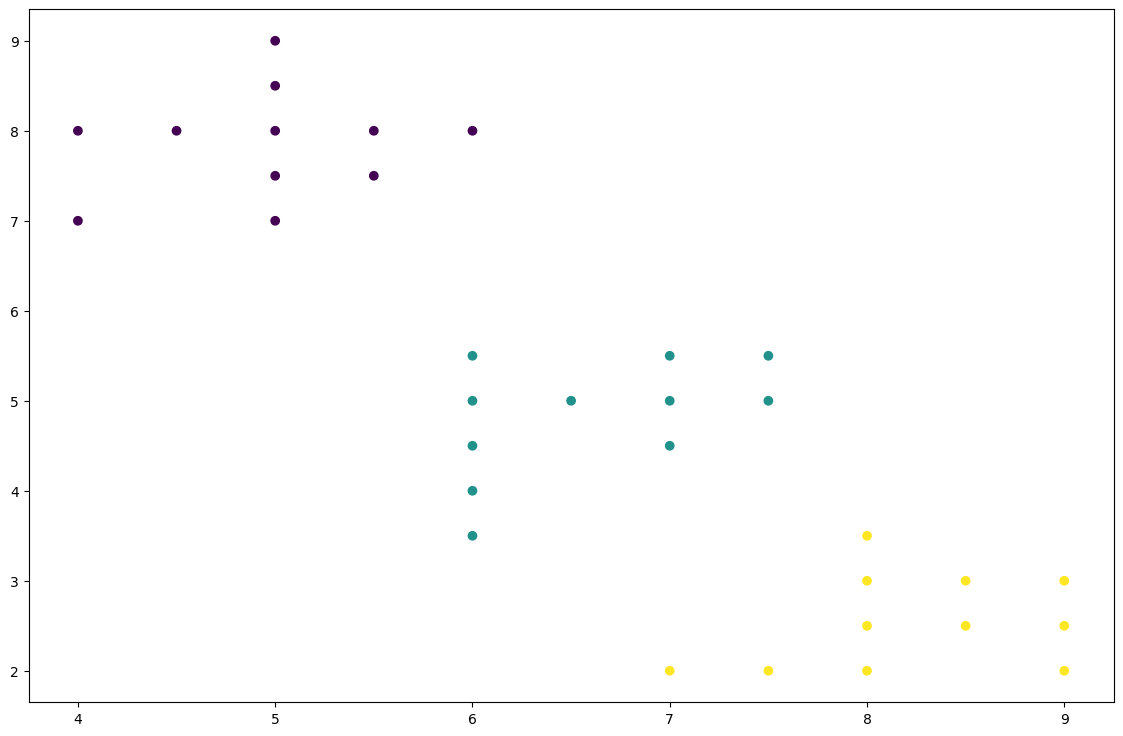

In [2]:
cluster_num = 3
points = [
    [4, 7], [4, 8], [4.5, 8], [5, 7], [5, 7.5], [5, 8], [5, 8.5], [5, 9], [5.5, 7.5], [5.5, 8], [6, 8],
    [6, 3.5], [6, 4], [6, 4.5], [6, 5], [6, 5.5], [6.5, 5], [7, 4.5], [7, 5], [7, 5.5], [7.5, 5], [7.5, 5.5],
    [7, 2], [7.5, 2], [8, 2], [8, 2.5], [8, 3], [8, 3.5], [8.5, 2.5], [8.5, 3], [9, 2], [9, 2.5], [9, 3],
]
labels = [0]*11 + [1]*11 + [2]*11
X, y = np.array(points), np.array(labels)
fig, ax = plt.subplots(figsize=(14, 9))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis');

The steps above are rather easy to follow,
so we can implement a k-means algorithm ourselves.
The following is a very simple implementation of k-means.
We perform step $1$ by first randomly assigning cluster centers,
step $2$ is performed with the `pairwise_distances` procedure.
The `pairwise_distances` procedure performs a matrix transformation
to generate distances between all points in the first and all
points in the second argument.
We did write our own version of `pairwise_distances` inside
the `fit` method when we implemented k nearest neighbors.
Computing the distances between all points is a very common
task in machine learning hence `sklearn` has a procedure for that.
And since we already implemented ourselves the procedure once,
we are now allowed to make our lives easier and
use the procedure provided.

Step $3$ is performed by taking the mean of the points in the cluster.
Remember that the mean is simply the center.
In our implementation we ignore the convergence and
just perform $6$ iterations to account for step $4$.
Finally, step $5$ is left in the `clusters` variable.

We plot the results.
Since k-means has the tendency of choking when a cluster center is not close enough to at least
one point, we may need to run the following several times until a good solution is found.
Note that we use a heuristic about initial cluster location,
we assume that our data centers close to zero and assign cluster centers
within the mean variance of the data from the origin.

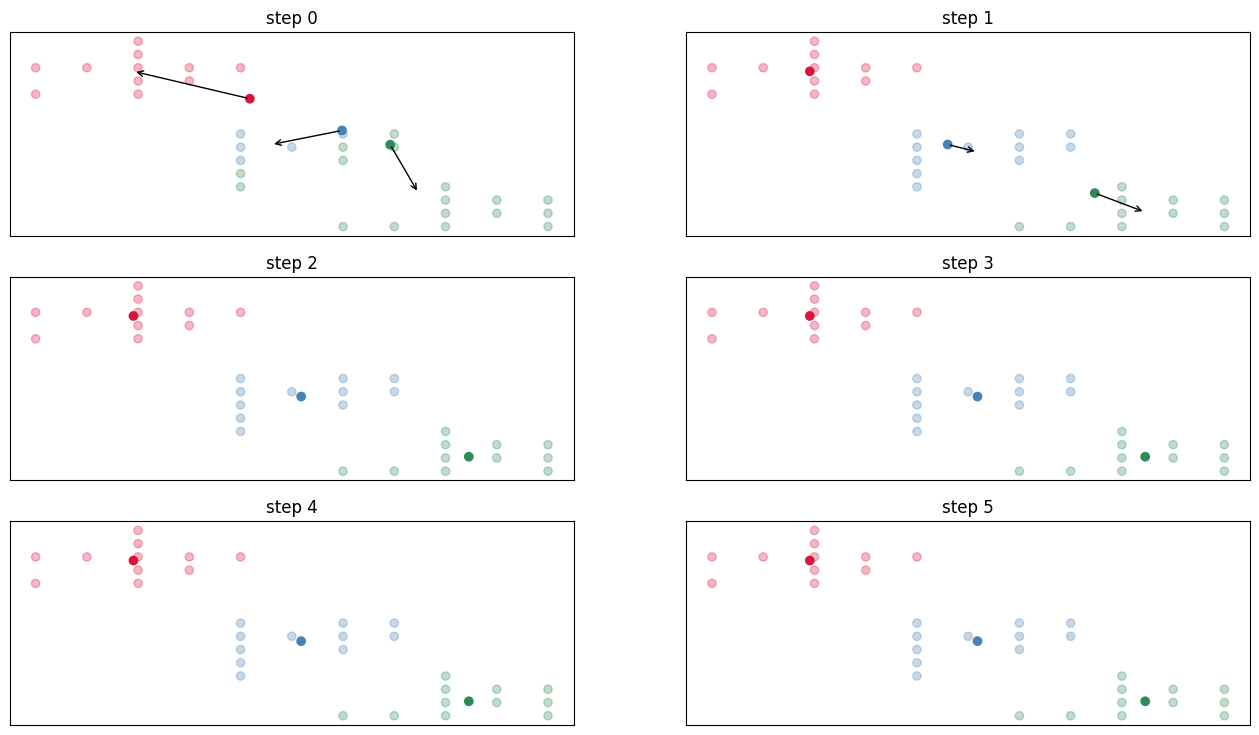

In [3]:
from sklearn.metrics import pairwise_distances

steps = 6
clusters = (np.random.rand(3, 2) - 0.5)*np.abs(X.mean(axis=0)) + X.mean(axis=0)
colors = np.array(['crimson', 'steelblue', 'seagreen'])
fig, ax = plt.subplots(3, 2, figsize=(16, 9))
for i in range(steps):
    distances = pairwise_distances(X, clusters)
    classes = distances.argmin(axis=1)
    ax.flat[i].scatter(clusters[:, 0], clusters[:, 1], c=colors);
    ax.flat[i].scatter(X[:, 0], X[:, 1], c=colors[classes], alpha=0.3);
    ax.flat[i].set(xticks=[], yticks=[], title=f'step {i}')
    new_clusters = np.array([]).reshape(0, 2)
    for j in range(cluster_num):
        centre = X[classes == j]
        if centre.shape[0]:
            new_clusters = np.r_['0,2', new_clusters, centre.mean(axis=0)]
        else:
            new_clusters = np.r_['0,2', new_clusters, clusters[j, :]]
        ax.flat[i].annotate('', new_clusters[j, :], clusters[j, :],
                            arrowprops=dict(arrowstyle='->', linewidth=1))
    clusters = new_clusters

## Limitations

One limitation of k-means that is apparent at first sight is that we need to know
a-priori the number of clusters we want to assign the data to.
Although measures such as *cluster inertia* across several numbers of clusters or a handful
of statistical techniques (e.g. silhouette analysis) exist to estimate a good number of clusters,
these are far from perfect.
Preexisting knowledge of the data,
possibly aided by dimensionality reduction is often needed to find a good number of clusters.

The algorithm requires stochastic initialization and,
given a bad initial start, may find a local minimum instead of a global minimum.
In other words badly initialized k-means can cluster badly.
In practice k-means is run for several random initializations and then evaluated.
Below the hood this is what the `sklearn` version of k-means does,
it runs the model fit several times and selects the best model.
(The number of times the k-means algorithm is initialized by `sklearn` is defined
by the `n_init=` argument to the class initialization.)

As long as the distance measure used is linear,
k-means is a linear algorithm and will only find clusters defined by linear borders.
Graph techniques such as spectral clustering or some versions of hierarchical clustering
are capable of dealing directly with non-linear clusters.
Yet, another viable trick is to pre-process the data with a manifold technique
and then cluster the projected data with (possibly a variant of) k-means.